# Random Forest regressor example

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

Generally a datascience problem starts with a question:
1. I want to buy a house in a very safe neighborhood for as little as possible.
2. I want to buy a house in a neighborhood that has the best chance of appreciation.

Then you find data that will help you answer questions. For instance;
1. You need crime records by zipcode/neighborhood and sales data, maybe generate a feature thats a combination of crime_score and average sales price. Output a list of safeest/lowest price neighborhoods
2. You need historical sales data (how far back is relevant?), information on schools including an unbiased rating, probably walkability indexes, proximity to hospital, traffic info.  Probably stitching together a lot of separate data sources.

We will do something a bit simpler here, just estimate a houses price based on a bunch of features


# Load Data


In [40]:
# !pip install wget

In [41]:
#get the data if you do not have it
import os
 
# Specify path
path='../datasets1'
file = '../datasets1/melb_data.csv'

#ceate if not there
if(not os.path.exists(path)):
    os.mkdir(path)
 
# Check whether file exists or not
if( not os.path.exists(file)):    
    import wget
    # Define the remote file to retrieve
    remote_url = 'https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/datasets/melb_data.csv'
    # Define the local filename to save data
    local_file = file
    # Make http request for remote file data
    wget.download(remote_url, local_file)

In [42]:
df = pd.read_csv("../datasets/melb_data.csv")
df.head()       
print(f'there are {len(df)} rows and {len(df.columns)} columns in df')

there are 13580 rows and 21 columns in df


In [43]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [44]:
df.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

## BTW if you are doing EDA or model building AND your dataset is large then work with a randomly sampled fraction of the data.

This will hugely speed up EDA and model training.  You should do this every time when you first start working with a dataset, especially if it's a large one.

<mark>When you finish tuning, finding hyperparameters and such, then use the FULL dataset

In [45]:
#get a fraction (10%) of the data to work on
# df=df.sample( frac=.1, replace=False, weights=None, random_state=42).reset_index(drop=True)

#get 10 rows to work on (used to demonstrate MAE below)
# df=df.sample( n=10, replace=False, weights=None, random_state=42).reset_index(drop=True)

print(f'there are {len(df)} rows in df')

there are 13580 rows in df


In [46]:
df.nunique()

Suburb             314
Address          13378
Rooms                9
Type                 3
Price             2204
Method               5
SellerG            268
Date                58
Distance           202
Postcode           198
Bedroom2            12
Bathroom             9
Car                 11
Landsize          1448
BuildingArea       602
YearBuilt          144
CouncilArea         33
Lattitude         6503
Longtitude        7063
Regionname           8
Propertycount      311
dtype: int64

## Lets strip some columns to make this demo easier

In [47]:
#lets strip out just a few columns to make this example easier
# Choose target and features
features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'Suburb','Postcode',
                        'YearBuilt', 'Lattitude', 'Longtitude']

#dependant variable (what you are estimating)
y = df.Price

#independant variables
df = df[features]

print(f'there are {len(df)} rows in df')

there are 13580 rows in df


In [48]:
#what types are we dealing with
df.dtypes

Rooms             int64
Bathroom        float64
Landsize        float64
BuildingArea    float64
Suburb           object
Postcode        float64
YearBuilt       float64
Lattitude       float64
Longtitude      float64
dtype: object

In [49]:
df.nunique()

Rooms              9
Bathroom           9
Landsize        1448
BuildingArea     602
Suburb           314
Postcode         198
YearBuilt        144
Lattitude       6503
Longtitude      7063
dtype: int64

In [51]:
#how many suburbs have NaNs for building area
df1=df.groupby('Suburb').BuildingArea.mean()
print(df1[df1.isna()])
ls=df1[df1.isna()].index

suburb_counts = df[df['Suburb'].isin(ls)].groupby('Suburb').size()
print(suburb_counts)


Suburb
Aspendale Gardens   NaN
Attwood             NaN
Bacchus Marsh       NaN
Bullengarook        NaN
Croydon South       NaN
Keilor Lodge        NaN
Monbulk             NaN
Officer             NaN
Rockbank            NaN
Silvan              NaN
Upwey               NaN
Name: BuildingArea, dtype: float64
Suburb
Aspendale Gardens    4
Attwood              1
Bacchus Marsh        1
Bullengarook         1
Croydon South        1
Keilor Lodge         2
Monbulk              1
Officer              1
Rockbank             1
Silvan               2
Upwey                1
dtype: int64


In [52]:
df.groupby('Suburb').BuildingArea.mean()

Suburb
Abbotsford      103.000000
Aberfeldie      163.692000
Airport West    135.272895
Albanvale       123.000000
Albert Park     123.485294
                   ...    
Wonga Park      177.000000
Wyndham Vale    154.885000
Yallambie       174.893333
Yarra Glen      180.560000
Yarraville      128.014694
Name: BuildingArea, Length: 314, dtype: float64

## Visualization: What can you tell by just plotting some stuff?

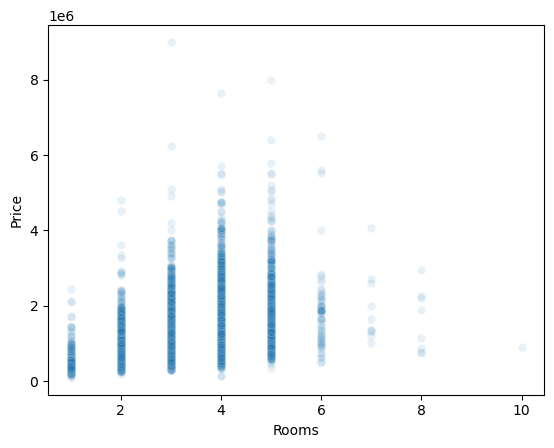

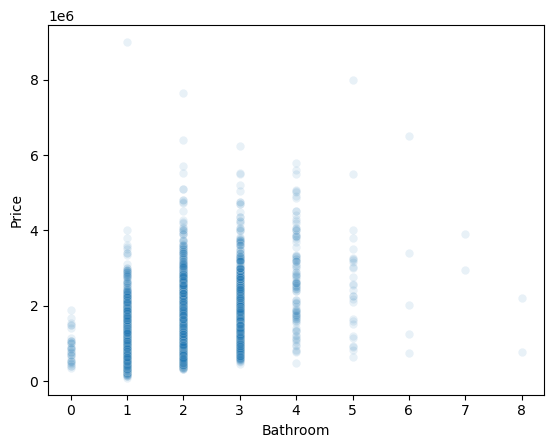

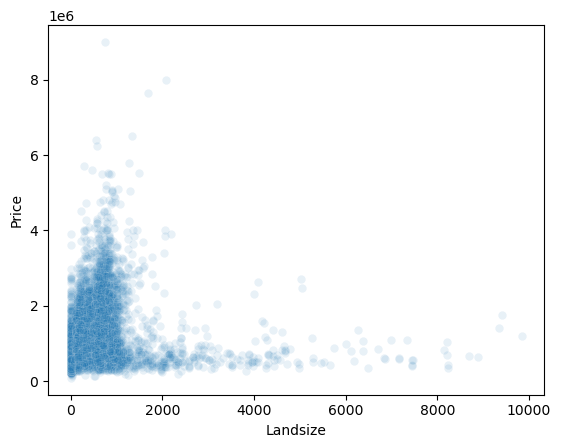

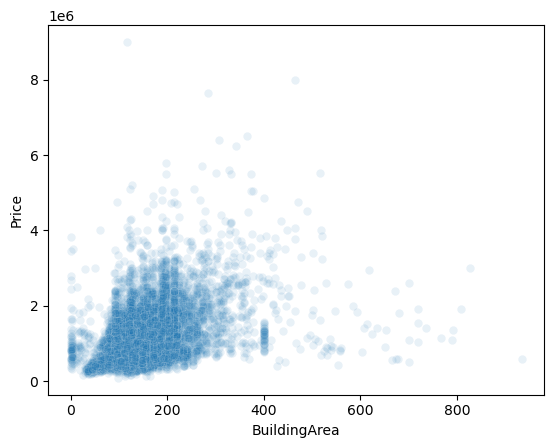

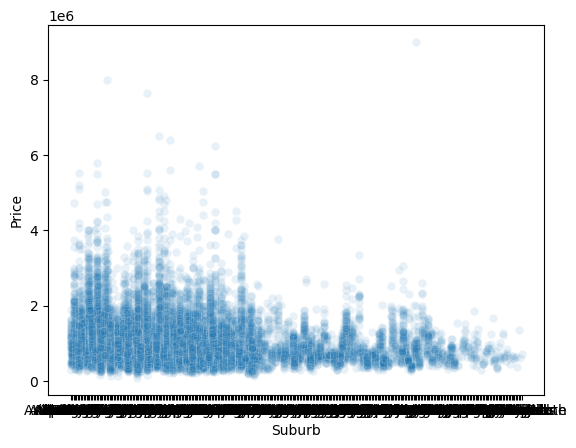

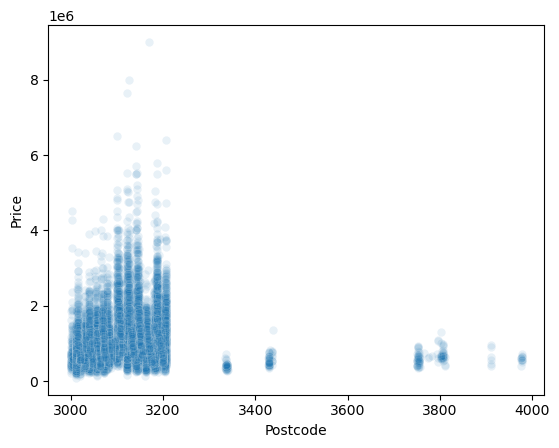

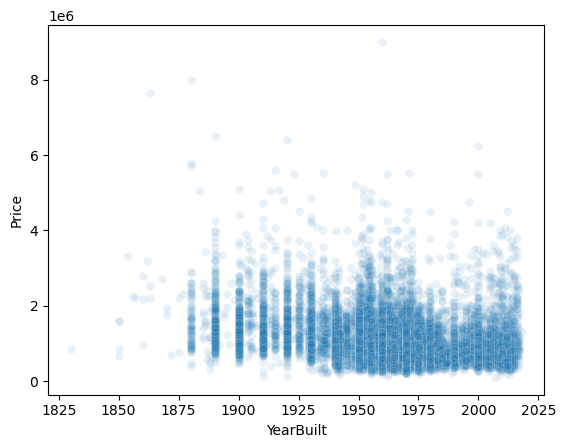

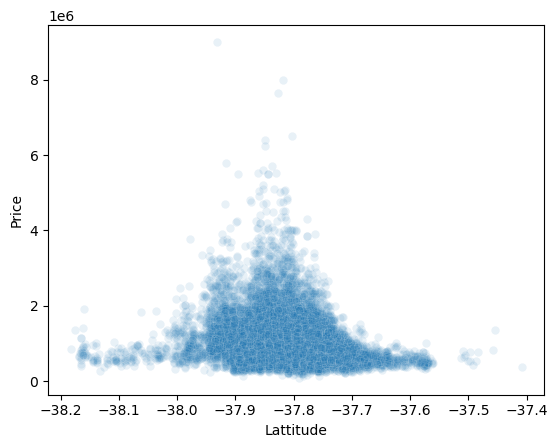

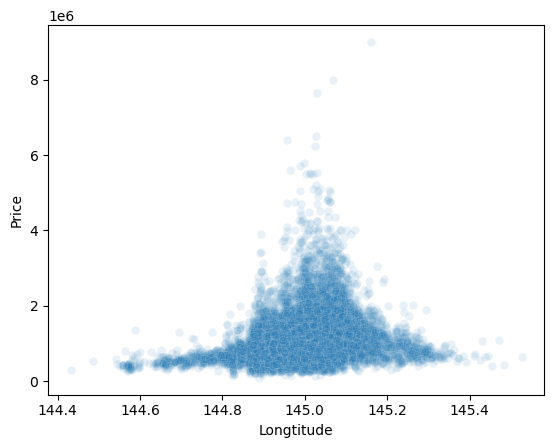

In [58]:
for col in features:
    _=plt.figure()
    _=sns.scatterplot(data=df,x=col,y=y, alpha=.1)

### From the above
1. I see most of the houses have between 2 and 5 rooms 
2. I also see most have between 1 and 3 bathrooms

My guess is the model will be best at predicting the price for houses 2-5 rooms and 1-3 bathrooms since there are so many examples for it to learn from

3. Landsize has some outliers, I'm sure the model will not do well predicting on houses that have land sizes>5000 since there are so few examples

4. Building area has outliers, either they are just wrong or its an apartment building mixed in with regular houses.  How will the model do here?

5. One YearBuilt is 1200AD. This is clearly wrong. (How would you fix this? See bottom of page)
6. Lattitude and longitude tell you where most of the houses are.  What do you think would happen if you clustered this data?


## Preprocess?
Don't have to do much for random forest (convert strings to numbers) and handle nulls, treat all catagoricals as ordinal.  Dont worry about normalization 

## Clean up NaNs

In [54]:
#first are there any?
df.isnull().sum()

Rooms              0
Bathroom           0
Landsize           0
BuildingArea    6450
Suburb             0
Postcode           0
YearBuilt       5375
Lattitude          0
Longtitude         0
dtype: int64

In [57]:
def fix_nans(col):
    def imputeval(df,targ_col,imput_col):
        #get average values based on imput_col
        sm=df.groupby(by=[imput_col])[targ_col].mean()

        #for a given row, look up and return the mean col
        def impute(x):
            return sm.loc[x[imput_col]]

        #replace NaNs with the average
        df[targ_col]=df.apply(lambda x:impute(x) if np.isnan(x[targ_col]) else x[targ_col],axis=1)

    imputeval(df,col,'Suburb')
    imputeval(df,col,'Postcode')
    #if here probably no good way to impute the remainders
    # dont want to drop them so set them to the column mean
    df[col]=df[col].fillna(df[col].mean())

fix_nans('YearBuilt')
fix_nans('BuildingArea')

## Remove the outliers to get better plots for Yearbuilt, BuildingArea and Landsize

In [56]:
#find and  set the bogus values to NaNs
df.loc[df['YearBuilt']<1700,'YearBuilt']=np.NaN
df.loc[df['BuildingArea']>1000,'BuildingArea']=np.NaN
df.loc[df['Landsize']>10000,'Landsize']=np.NaN

fix_nans('YearBuilt')
fix_nans('Landsize')
fix_nans('BuildingArea')

In [59]:
#dont need Postcode
df.drop(columns=['Postcode'], inplace=True)
features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea','Suburb' ,
                        'YearBuilt', 'Lattitude', 'Longtitude']

## Suburb probably captures excellent info about value, encode it

In [60]:
list(df.Suburb.unique())
# df.Suburb

['Abbotsford',
 'Airport West',
 'Albert Park',
 'Alphington',
 'Altona',
 'Altona North',
 'Armadale',
 'Ascot Vale',
 'Ashburton',
 'Ashwood',
 'Avondale Heights',
 'Balaclava',
 'Balwyn',
 'Balwyn North',
 'Bentleigh',
 'Bentleigh East',
 'Box Hill',
 'Braybrook',
 'Brighton',
 'Brighton East',
 'Brunswick',
 'Brunswick West',
 'Bulleen',
 'Burwood',
 'Camberwell',
 'Canterbury',
 'Carlton North',
 'Carnegie',
 'Caulfield',
 'Caulfield North',
 'Caulfield South',
 'Chadstone',
 'Clifton Hill',
 'Coburg',
 'Coburg North',
 'Collingwood',
 'Doncaster',
 'Eaglemont',
 'Elsternwick',
 'Elwood',
 'Essendon',
 'Essendon North',
 'Fairfield',
 'Fitzroy',
 'Fitzroy North',
 'Flemington',
 'Footscray',
 'Glen Iris',
 'Glenroy',
 'Gowanbrae',
 'Hadfield',
 'Hampton',
 'Hampton East',
 'Hawthorn',
 'Heidelberg Heights',
 'Heidelberg West',
 'Hughesdale',
 'Ivanhoe',
 'Kealba',
 'Keilor East',
 'Kensington',
 'Kew',
 'Kew East',
 'Kooyong',
 'Maidstone',
 'Malvern',
 'Malvern East',
 'Maribyrno

In [61]:
#encode the suburbs (its OK to encode as ordinal for Random Forest)
suburb_map={i:v for v,i in enumerate(list(df.Suburb.unique()))}
df.Suburb=df.Suburb.map(suburb_map)

In [62]:
df.dtypes

Rooms             int64
Bathroom        float64
Landsize        float64
BuildingArea    float64
Suburb            int64
YearBuilt       float64
Lattitude       float64
Longtitude      float64
dtype: object

# Analysis

How are we going to see if we are right?  We cannot use accuracy here like we did for classification since we are predicting a floating point number, and even if 2 floating point numbers are very close, in a boolean expression they will not be equal (ex 0.002 != 0.002001).

So what to do?  Measure the difference between the true value and the predicted value or each point, sum these differences, and then divide by the number of points.  This is called the <mark>mean_absolute_error</mark> and it's given by the formula below.
![](./mae_form.png)

A MAE of 0 means your model is perfect 

In [64]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(df, y,random_state = 0)

In [65]:
#BTW mean absolute error is simple, here is an implementation
def mae(val_y, preds):
    tots=0
    for y,p in zip(val_y, preds):
        tots=tots +np.abs(p-y)
    return tots/len(val_y)

#but you are better off using sklearns implementation (less code to write)
from sklearn.metrics import mean_absolute_error

### What's the average house price?

In [66]:
y.mean()

1075684.079455081

### Train a Decision tree Regressor (remember this is a single tree)

Scikitlearn estimators work the same way,;
1. Fit estimator to the training data
2. Generate predictions on validation data
3. Use an error metric to determine how good model is

In [67]:
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [68]:
#1. Fit estimator to the training data
clf = tree.DecisionTreeRegressor()
clf=clf.fit(train_X,train_y)

# 2. Generate predictions on validation data
preds=clf.predict(val_X)

# 3. Use an error metric to determine how good model is
print(f'MAE={mean_absolute_error(val_y,preds)}')


MAE=251379.8384879725


In [69]:
#verify that home rolled mae is the same as sklearns mean_absolute_error
print(f'mae error={mae(val_y, preds)}')

mae error=251379.8384879725


### Then train a random forest regressor (lots of decision trees)

#### A word about OOB error

Scikitlearns RandomForestRegressor defaults to r2_score if you do not provide an error metric for OOB score. We prefer MAE so set it, but to what? 
Look up RandomForestRegressor and see what options are available
<code> 
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42, oob_score=True)
RandomForestRegressor??
</code>

In [70]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42, oob_score=mean_absolute_error)
RandomForestRegressor??

Init signature:
RandomForestRegressor(
    n_estimators=100,
    *,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
Source:        
class RandomForestRegressor(ForestRegressor):
    """
    A random forest regressor.

    A random forest is a meta estimator that fits a number of classifying
    decision trees on various sub-samples of the dataset and uses averaging
    to improve the predictive accuracy and control over-fitting.
    The sub-sample size is controlled with the `max_samples` parameter if
    `bootstrap=True` (default), otherwise the whole dataset is used to build
    each tree.

    For a comparison between tree-based ensemble models see the example
   

In [71]:
#1. Fit estimator to the training data
clf=RandomForestRegressor(oob_score=mean_absolute_error)  #or mae for oob_score
clf=clf.fit(train_X,train_y)

# 2. Generate predictions on validation data
preds=clf.predict(val_X)

# 3. Use an error metric to determine how good model is
print(f'MAE={mean_absolute_error(val_y,preds)}')

#4 lets see the models OOB score (different from above since above is predicting on val set and this is predicting
#  on OOB set)
print(f'Models OOB score={clf.oob_score_}')

MAE=176896.84852472125
Models OOB score=181195.48217858485


In [72]:
df.head()

,Rooms,Bathroom,Landsize,BuildingArea,Suburb,YearBuilt,Lattitude,Longtitude
0,2,1.0,202.0,103.0,0,1945.184211,-37.7996,144.9984
1,2,1.0,156.0,79.0,0,1900.000000,-37.8079,144.9934
2,3,2.0,134.0,150.0,0,1900.000000,-37.8093,144.9944
3,3,2.0,94.0,103.0,0,1945.184211,-37.7969,144.9969
4,4,1.0,120.0,142.0,0,2014.000000,-37.8072,144.9941


### The mean absolute error for the random forest is considerably less than the decision tree 

### Remember what I said above about how I thought the model would do well on houses with 2-5 rooms and 1-3 bathrooms since there are so many examples for it to learn from? Lets see if thats true


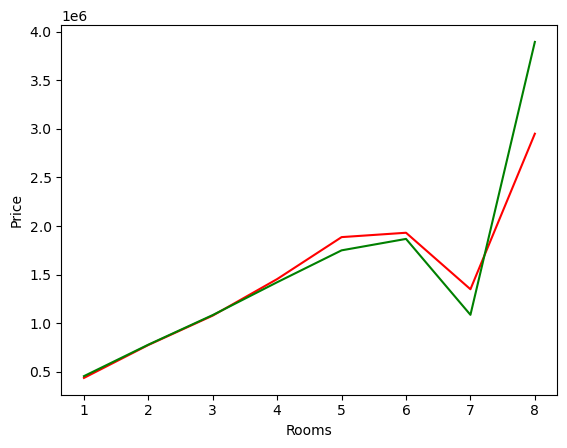

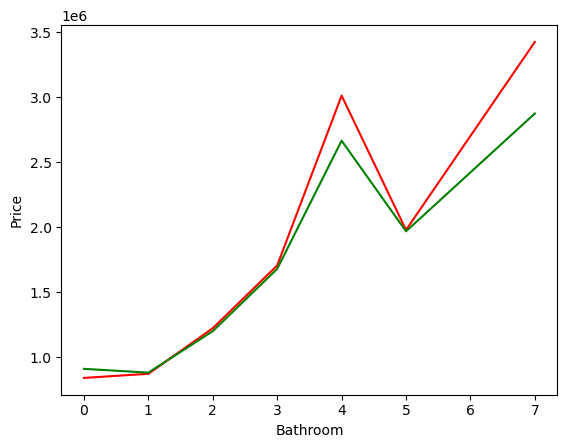

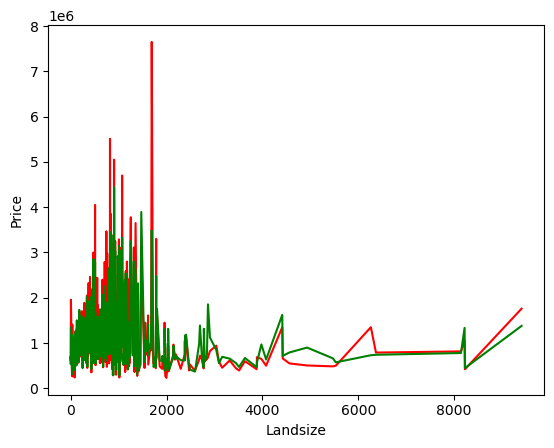

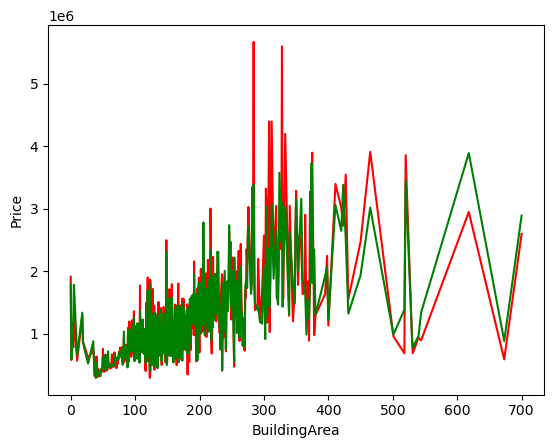

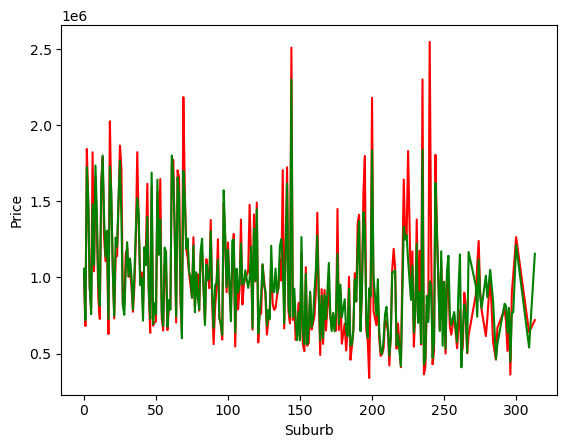

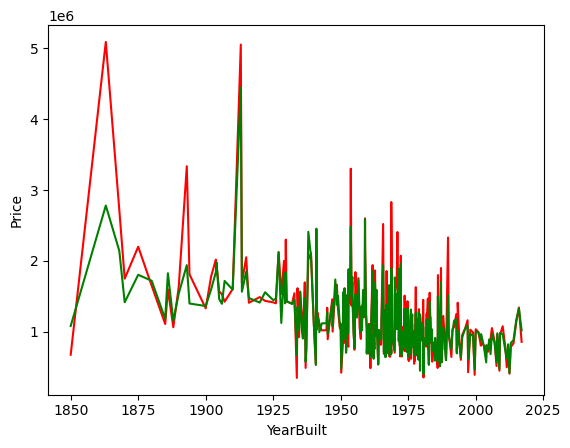

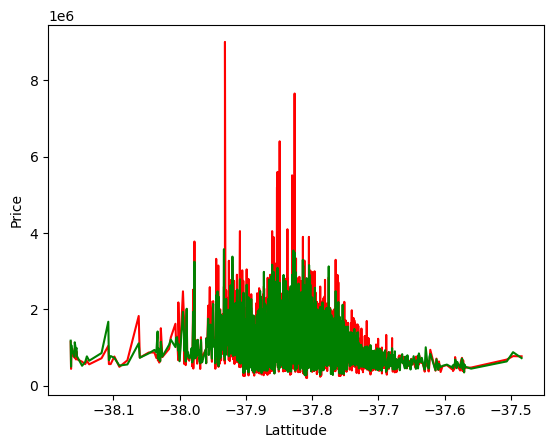

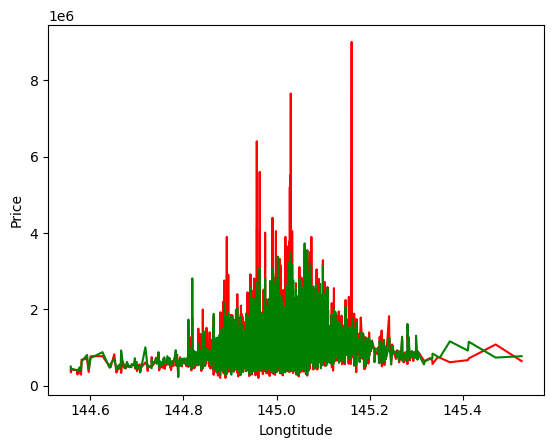

In [73]:
for col in features:
    _=plt.figure()
    # _=sns.lineplot(data=val_X,x=col,y=val_y, alpha=1,errorbar=None,palette=['red'])
    # _=sns.lineplot(data=val_X,x=col,y=preds, alpha=1,errorbar=None,palette=['green'])
    _=sns.lineplot(data=val_X,x=col,y=val_y, alpha=1,errorbar=None,color='red')
    _=sns.lineplot(data=val_X,x=col,y=preds, alpha=1,errorbar=None,color='green')